In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras


import flwr as fl
import matplotlib.pyplot as plt
import numpy as np 
from typing import List, Tuple
from flwr.common import Metrics
import ray
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()


2024-02-13 03:19:10.577471: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 03:19:10.604769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 03:19:10.604795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 03:19:10.605568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 03:19:10.610561: I tensorflow/core/platform/cpu_feature_guar

# Data Processing

In [2]:
def getMnistData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'mnist',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [3]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255 

In [4]:
def split_intoPartition(data, num_partitions):
    # Calculate the size of each partition
    partition_size = len(data) // num_partitions
    # Split the dataset into partitions
    partitions = [data[i * partition_size:(i + 1) * partition_size] for i in range(num_partitions)]
    return partitions    

In [5]:
trainset,testset, info = getMnistData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)

2024-02-13 03:19:12.111273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 03:19:12.111425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-13 03:19:12.111484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

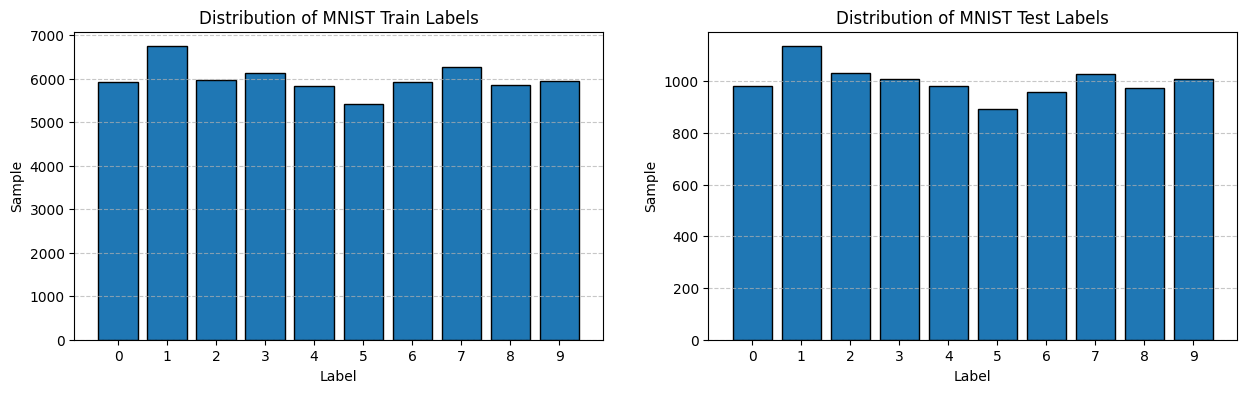

In [6]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of MNIST Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of MNIST Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [7]:
NumOfPartition = 2
train_image_part = split_intoPartition(Train_images_n,NumOfPartition)
train_label_part = split_intoPartition(Train_label,NumOfPartition)

# train_image_part,train_label_part,test_image_part,test_label_part

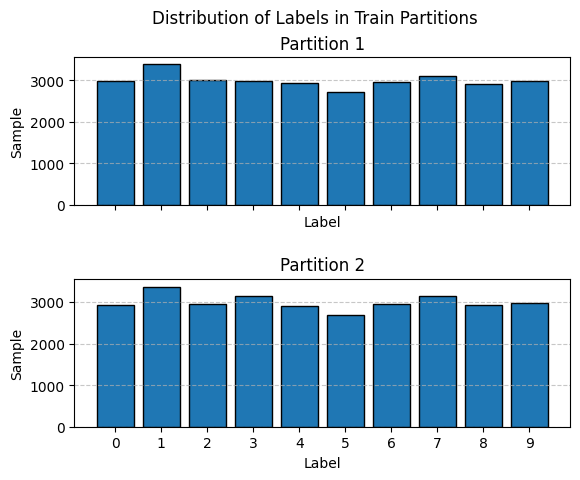

In [8]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

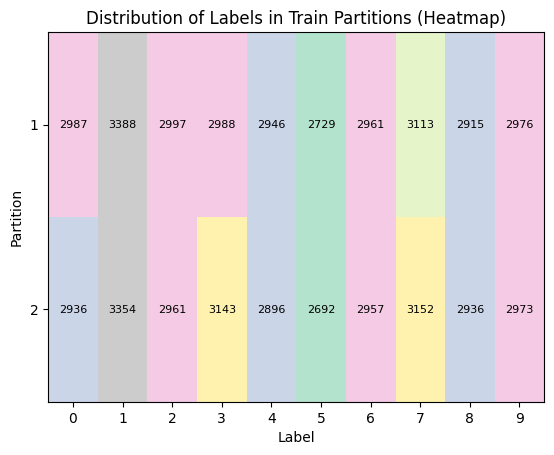

In [9]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [10]:
def LRmodel():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28, 1)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [11]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model
        
    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set, 
                                 y=self.train_label_set,
                                 verbose=2, 
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")       
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")       
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [12]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 50,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]
    
    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [13]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [14]:
globalmodel = LRmodel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [15]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 8, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-13 03:19:18,549 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-13 03:19:20,301	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2024-02-13 03:19:21,026 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3556573593.0, 'memory': 7113147188.0, 'CPU': 16.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:10.91.229.129': 1.0, 'object_store_memory': 3556573593.0, 'memory': 7113147188.0, 'CPU': 16.0, 'GPU': 1.0, 'accelerator_type:G': 1.0}
INFO flwr 2024-02-13 03:19:21,027 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Opti

(DefaultActor pid=117824) round :1
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50


(DefaultActor pid=117824) 2024-02-13 03:19:23.189226: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efc74305c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
(DefaultActor pid=117824) 2024-02-13 03:19:23.189269: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
(DefaultActor pid=117824) 2024-02-13 03:19:23.194152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
(DefaultActor pid=117824) 2024-02-13 03:19:23.205948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
(DefaultActor pid=117824) 2024-02-13 03:19:23.226025: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
(DefaultActor pid=117824) WARNING: All log messages before 

(DefaultActor pid=117824) 938/938 - 2s - loss: 0.5890 - accuracy: 0.8512 - val_loss: 0.3549 - val_accuracy: 0.9047 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.3358 - accuracy: 0.9071 - val_loss: 0.3075 - val_accuracy: 0.9144 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.3005 - accuracy: 0.9169 - val_loss: 0.2942 - val_accuracy: 0.9181 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2838 - accuracy: 0.9210 - val_loss: 0.2878 - val_accuracy: 0.9187 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2720 - accuracy: 0.9227 - val_loss: 0.2792 - val_accuracy: 0.9220 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2640 - accuracy: 0.9253 - val_loss: 0.2761 - val_accuracy: 0.9229 - 1s/epoch - 1m

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.5963 - accuracy: 0.8519 - val_loss: 0.3543 - val_accuracy: 0.9072 - 1s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.3448 - accuracy: 0.9063 - val_loss: 0.3119 - val_accuracy: 0.9151 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.3112 - accuracy: 0.9156 - val_loss: 0.2945 - val_accuracy: 0.9174 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2937 - accuracy: 0.9197 - val_loss: 0.2850 - val_accuracy: 0.9196 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2831 - accuracy: 0.9227 - val_loss: 0.2813 - val_accuracy: 0.9215 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2746 - accuracy: 0.9250 - val_loss: 0.2788 -

DEBUG flwr 2024-02-13 03:21:12,866 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:21:12,868 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2120 - accuracy: 0.9414 - val_loss: 0.2935 - val_accuracy: 0.9247 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.2725 - accuracy: 0.9287 - 5s/epoch - 541us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:21:23,737 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:21:23,737 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.2725 - accuracy: 0.9287 - 5s/epoch - 523us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :2
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2431 - accuracy: 0.9340 - val_loss: 0.2773 - val_accuracy: 0.9270 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2381 - accuracy: 0.9348 - val_loss: 0.2781 - val_accuracy: 0.9273 - 965ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2351 - accuracy: 0.9360 - val_loss: 0.2805 - val_accuracy: 0.9277 - 999ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2332 - accuracy: 0.9362 - val_loss: 0.2823 - val_accuracy: 0.9269 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/5

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2309 - accuracy: 0.9347 - val_loss: 0.2771 - val_accuracy: 0.9273 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2264 - accuracy: 0.9361 - val_loss: 0.2789 - val_accuracy: 0.9284 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2237 - accuracy: 0.9376 - val_loss: 0.2808 - val_accuracy: 0.9276 - 960ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2222 - accuracy: 0.9375 - val_loss: 0.2773 - val_accuracy: 0.9279 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2203 - accuracy: 0.9388 - val_loss: 0.2800 - val_accuracy: 0.9285 - 995ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2188 - accuracy: 0.9388 - val_loss: 0.

DEBUG flwr 2024-02-13 03:23:07,462 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:23:07,464 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1938 - accuracy: 0.9462 - val_loss: 0.3066 - val_accuracy: 0.9238 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.2891 - accuracy: 0.9280 - 5s/epoch - 523us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:23:18,274 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:23:18,275 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.2891 - accuracy: 0.9280 - 5s/epoch - 535us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :3
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2364 - accuracy: 0.9355 - val_loss: 0.2924 - val_accuracy: 0.9275 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2315 - accuracy: 0.9365 - val_loss: 0.2940 - val_accuracy: 0.9267 - 993ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2280 - accuracy: 0.9382 - val_loss: 0.2964 - val_accuracy: 0.9263 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2263 - accuracy: 0.9377 - val_loss: 0.2975 - val_accuracy: 0.9255 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2254 - accuracy: 0.9363 - val_loss: 0.2927 - val_accuracy: 0.9266 - 1s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2206 - accuracy: 0.9377 - val_loss: 0.2903 - val_accuracy: 0.9283 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2180 - accuracy: 0.9389 - val_loss: 0.2955 - val_accuracy: 0.9246 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2156 - accuracy: 0.9390 - val_loss: 0.2949 - val_accuracy: 0.9250 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2139 - accuracy: 0.9399 - val_loss: 0.2971 - val_accuracy: 0.9258 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2127 - accuracy: 0.9412 - val_loss: 0.2947 -

DEBUG flwr 2024-02-13 03:25:12,152 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:25:12,154 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1890 - accuracy: 0.9473 - val_loss: 0.3194 - val_accuracy: 0.9213 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 7s - loss: 0.3034 - accuracy: 0.9274 - 7s/epoch - 683us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:25:26,157 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:25:26,158 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 7s - loss: 0.3034 - accuracy: 0.9274 - 7s/epoch - 684us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :4
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2221 - accuracy: 0.9369 - val_loss: 0.3030 - val_accuracy: 0.9269 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2177 - accuracy: 0.9383 - val_loss: 0.3053 - val_accuracy: 0.9267 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2153 - accuracy: 0.9391 - val_loss: 0.3019 - val_accuracy: 0.9269 - 1s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2124 - accuracy: 0.9394 - val_loss: 0.3061 - val_accuracy: 0.9260 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(Def

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2333 - accuracy: 0.9361 - val_loss: 0.3040 - val_accuracy: 0.9283 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2281 - accuracy: 0.9377 - val_loss: 0.3073 - val_accuracy: 0.9252 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2248 - accuracy: 0.9378 - val_loss: 0.3068 - val_accuracy: 0.9251 - 976ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2227 - accuracy: 0.9390 - val_loss: 0.3086 - val_accuracy: 0.9258 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2205 - accuracy: 0.9391 - val_loss: 0.3128 - val_accuracy: 0.9233 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2195 - accuracy: 0.9397 - val_loss: 0.309

DEBUG flwr 2024-02-13 03:27:17,187 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:27:17,189 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1970 - accuracy: 0.9452 - val_loss: 0.3356 - val_accuracy: 0.9185 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3106 - accuracy: 0.9261 - 5s/epoch - 515us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:27:27,814 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:27:27,815 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3106 - accuracy: 0.9261 - 5s/epoch - 522us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :5
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2310 - accuracy: 0.9365 - val_loss: 0.3166 - val_accuracy: 0.9265 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2261 - accuracy: 0.9380 - val_loss: 0.3166 - val_accuracy: 0.9262 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2232 - accuracy: 0.9377 - val_loss: 0.3186 - val_accuracy: 0.9234 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2207 - accuracy: 0.9392 - val_loss: 0.3199 - val_accuracy: 0.9214 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(Def

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2204 - accuracy: 0.9368 - val_loss: 0.3117 - val_accuracy: 0.9257 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2155 - accuracy: 0.9397 - val_loss: 0.3133 - val_accuracy: 0.9238 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2132 - accuracy: 0.9402 - val_loss: 0.3144 - val_accuracy: 0.9247 - 976ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2109 - accuracy: 0.9404 - val_loss: 0.3119 - val_accuracy: 0.9265 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2089 - accuracy: 0.9415 - val_loss: 0.3148 - val_accuracy: 0.9264 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2075 - accuracy: 0.9413 - val_loss: 0.314

DEBUG flwr 2024-02-13 03:29:13,784 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:29:13,787 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1858 - accuracy: 0.9486 - val_loss: 0.3345 - val_accuracy: 0.9190 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3189 - accuracy: 0.9273 - 5s/epoch - 548us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:29:24,917 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:29:24,918 | server.py:222 | fit_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3189 - accuracy: 0.9273 - 5s/epoch - 538us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :6
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2190 - accuracy: 0.9378 - val_loss: 0.3189 - val_accuracy: 0.9249 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2145 - accuracy: 0.9400 - val_loss: 0.3177 - val_accuracy: 0.9268 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2116 - accuracy: 0.9399 - val_loss: 0.3204 - val_accuracy: 0.9238 - 929ms/epoch - 990us/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2090 - accuracy: 0.9417 - val_loss: 0.3228 - val_accuracy: 0.9235 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2295 - accuracy: 0.9377 - val_loss: 0.3227 - val_accuracy: 0.9263 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2247 - accuracy: 0.9383 - val_loss: 0.3214 - val_accuracy: 0.9263 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2216 - accuracy: 0.9381 - val_loss: 0.3247 - val_accuracy: 0.9269 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2193 - accuracy: 0.9402 - val_loss: 0.3249 - val_accuracy: 0.9244 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2174 - accuracy: 0.9398 - val_loss: 0.3279 - val_accuracy: 0.9238 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2159 - accuracy: 0.9405 - val_loss: 0.3280 -

DEBUG flwr 2024-02-13 03:31:13,036 | server.py:236 | fit_round 6 received 2 results and 0 failures
DEBUG:flwr:fit_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:31:13,038 | server.py:173 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 6: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1940 - accuracy: 0.9459 - val_loss: 0.3495 - val_accuracy: 0.9173 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3231 - accuracy: 0.9256 - 5s/epoch - 540us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:31:24,111 | server.py:187 | evaluate_round 6 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:31:24,112 | server.py:222 | fit_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3231 - accuracy: 0.9256 - 5s/epoch - 545us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :7
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2181 - accuracy: 0.9384 - val_loss: 0.3297 - val_accuracy: 0.9225 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2138 - accuracy: 0.9395 - val_loss: 0.3217 - val_accuracy: 0.9253 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2107 - accuracy: 0.9409 - val_loss: 0.3252 - val_accuracy: 0.9237 - 984ms/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2088 - accuracy: 0.9422 - val_loss: 0.3266 - val_accuracy: 0.9238 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2292 - accuracy: 0.9365 - val_loss: 0.3292 - val_accuracy: 0.9237 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2239 - accuracy: 0.9377 - val_loss: 0.3299 - val_accuracy: 0.9242 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2213 - accuracy: 0.9383 - val_loss: 0.3278 - val_accuracy: 0.9252 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2180 - accuracy: 0.9388 - val_loss: 0.3282 - val_accuracy: 0.9244 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2168 - accuracy: 0.9405 - val_loss: 0.3336 - val_accuracy: 0.9242 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2146 - accuracy: 0.9419 - val_loss: 0.3313 -

DEBUG flwr 2024-02-13 03:33:33,402 | server.py:236 | fit_round 7 received 2 results and 0 failures
DEBUG:flwr:fit_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:33:33,404 | server.py:173 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 7: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1934 - accuracy: 0.9456 - val_loss: 0.3539 - val_accuracy: 0.9182 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 6s - loss: 0.3285 - accuracy: 0.9253 - 6s/epoch - 582us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:33:47,877 | server.py:187 | evaluate_round 7 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:33:47,878 | server.py:222 | fit_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 8: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 8s - loss: 0.3285 - accuracy: 0.9253 - 8s/epoch - 840us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :8
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2286 - accuracy: 0.9374 - val_loss: 0.3315 - val_accuracy: 0.9266 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2232 - accuracy: 0.9379 - val_loss: 0.3384 - val_accuracy: 0.9232 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2206 - accuracy: 0.9387 - val_loss: 0.3363 - val_accuracy: 0.9228 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2178 - accuracy: 0.9398 - val_loss: 0.3366 - val_accuracy: 0.9228 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 5/50
(Def

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 2s - loss: 0.2177 - accuracy: 0.9382 - val_loss: 0.3304 - val_accuracy: 0.9252 - 2s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2126 - accuracy: 0.9400 - val_loss: 0.3329 - val_accuracy: 0.9231 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2109 - accuracy: 0.9410 - val_loss: 0.3368 - val_accuracy: 0.9220 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2087 - accuracy: 0.9418 - val_loss: 0.3339 - val_accuracy: 0.9224 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2069 - accuracy: 0.9417 - val_loss: 0.3351 - val_accuracy: 0.9237 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2047 - accuracy: 0.9425 - val_loss: 0.3317 -

DEBUG flwr 2024-02-13 03:35:42,168 | server.py:236 | fit_round 8 received 2 results and 0 failures
DEBUG:flwr:fit_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:35:42,170 | server.py:173 | evaluate_round 8: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 8: strategy sampled 2 clients (out of 2)


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1829 - accuracy: 0.9493 - val_loss: 0.3592 - val_accuracy: 0.9190 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 6s - loss: 0.3340 - accuracy: 0.9246 - 6s/epoch - 560us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:35:53,594 | server.py:187 | evaluate_round 8 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:35:53,595 | server.py:222 | fit_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 6s - loss: 0.3340 - accuracy: 0.9246 - 6s/epoch - 557us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :9
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2283 - accuracy: 0.9373 - val_loss: 0.3362 - val_accuracy: 0.9257 - 1s/epoch - 2ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2226 - accuracy: 0.9389 - val_loss: 0.3436 - val_accuracy: 0.9226 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2202 - accuracy: 0.9394 - val_loss: 0.3392 - val_accuracy: 0.9240 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2175 - accuracy: 0.9397 - val_loss: 0.3432 - val_accuracy: 0.9222 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(Def

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2174 - accuracy: 0.9388 - val_loss: 0.3349 - val_accuracy: 0.9244 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2124 - accuracy: 0.9400 - val_loss: 0.3332 - val_accuracy: 0.9250 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2100 - accuracy: 0.9412 - val_loss: 0.3351 - val_accuracy: 0.9233 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2077 - accuracy: 0.9419 - val_loss: 0.3382 - val_accuracy: 0.9241 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2064 - accuracy: 0.9429 - val_loss: 0.3370 - val_accuracy: 0.9241 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2044 - accuracy: 0.9434 - val_loss: 0.3401 -

DEBUG flwr 2024-02-13 03:37:42,985 | server.py:236 | fit_round 9 received 2 results and 0 failures
DEBUG:flwr:fit_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:37:42,986 | server.py:173 | evaluate_round 9: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 9: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1825 - accuracy: 0.9503 - val_loss: 0.3577 - val_accuracy: 0.9191 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 6s - loss: 0.3381 - accuracy: 0.9251 - 6s/epoch - 561us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:37:54,036 | server.py:187 | evaluate_round 9 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:37:54,037 | server.py:222 | fit_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3381 - accuracy: 0.9251 - 5s/epoch - 522us/step
(DefaultActor pid=117824) Global Validate Done!!!
(DefaultActor pid=117824) round :10
(DefaultActor pid=117824) Train :30000
(DefaultActor pid=117824) Test :10000
(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2170 - accuracy: 0.9387 - val_loss: 0.3393 - val_accuracy: 0.9228 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2123 - accuracy: 0.9406 - val_loss: 0.3411 - val_accuracy: 0.9232 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2091 - accuracy: 0.9407 - val_loss: 0.3412 - val_accuracy: 0.9226 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2070 - accuracy: 0.9420 - val_loss: 0.3397 - val_accuracy: 0.9228 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(De

(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) Epoch 1/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2282 - accuracy: 0.9371 - val_loss: 0.3481 - val_accuracy: 0.9235 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 2/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2231 - accuracy: 0.9390 - val_loss: 0.3468 - val_accuracy: 0.9226 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 3/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2192 - accuracy: 0.9395 - val_loss: 0.3491 - val_accuracy: 0.9219 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 4/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2172 - accuracy: 0.9400 - val_loss: 0.3488 - val_accuracy: 0.9211 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 5/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2156 - accuracy: 0.9396 - val_loss: 0.3466 - val_accuracy: 0.9235 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Epoch 6/50
(DefaultActor pid=117824) 938/938 - 1s - loss: 0.2139 - accuracy: 0.9406 - val_loss: 0.3446 -

DEBUG flwr 2024-02-13 03:39:52,104 | server.py:236 | fit_round 10 received 2 results and 0 failures
DEBUG:flwr:fit_round 10 received 2 results and 0 failures
DEBUG flwr 2024-02-13 03:39:52,105 | server.py:173 | evaluate_round 10: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 10: strategy sampled 2 clients (out of 2)
(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=117824) 938/938 - 1s - loss: 0.1914 - accuracy: 0.9466 - val_loss: 0.3688 - val_accuracy: 0.9173 - 1s/epoch - 1ms/step
(DefaultActor pid=117824) Client Train and validate Done!!!
(DefaultActor pid=117824) 10000/10000 - 6s - loss: 0.3420 - accuracy: 0.9251 - 6s/epoch - 559us/step
(DefaultActor pid=117824) Global Validate Done!!!


(DefaultActor pid=117824) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 5 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-13 03:40:03,376 | server.py:187 | evaluate_round 10 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 2 results and 0 failures
INFO flwr 2024-02-13 03:40:03,376 | server.py:153 | FL finished in 1240.6815865890003
INFO:flwr:FL finished in 1240.6815865890003
INFO flwr 2024-02-13 03:40:03,377 | app.py:226 | app_fit: losses_distributed [(1, 0.2725292444229126), (2, 0.28909119963645935), (3, 0.3034495711326599), (4, 0.31058284640312195), (5, 0.31886711716651917), (6, 0.3231416642665863), (7, 0.32853394746780396), (8, 0.3340345621109009), (9, 0.3381477892398834), (10, 0.34198248386383057)]
INFO:flwr:app_fit: losses_distributed [(1, 0.2725292444229126), (2, 0.28909119963645935), (3, 0.3034495711326599), (4, 0.31058284640312195), (5, 0.31886711716651917), (6, 0.3231416642665863), (7, 0.3285339474

In [16]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

(DefaultActor pid=117824) 10000/10000 - 5s - loss: 0.3420 - accuracy: 0.9251 - 5s/epoch - 543us/step
(DefaultActor pid=117824) Global Validate Done!!!


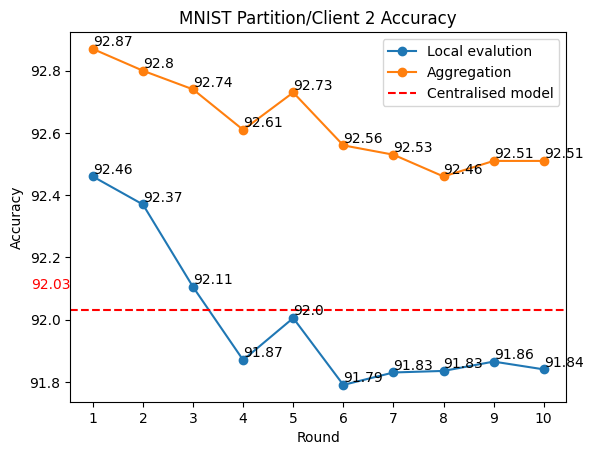

In [17]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"MNIST Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 92.03
plt.gca().text(0, average_value/300, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()